In [1]:
from fhd import *
import OpenEphys
import matplotlib.pyplot as plt
import numpy as np
from kaveh.toolbox import find_files_regex
import pandas as pd
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# 1. Sorting Complex Spikes:

In [5]:
# source_path = '../data/OpenEphys_data/2019-03-26/2019-03-26_17-40-47/'
# source_path = '../data/OpenEphys_data/2019-03-26/2019-03-26_18-27-55/'
# source_path = '../data/OpenEphys_data/2019-03-27/2019-03-27_13-58-03/'
# source_path = '../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/'
source_path = '../data/OpenEphys_data/2019-11-19/2019-11-19_12-44-32/'

chan_index = 5

num_channels = 7
chan_index = chan_index - 1
raw_data = source_path + 'raw_data'
analyzed_data = source_path + 'analyzed_data'


In [6]:
f_names = []
f_names_cmn = []
for root, dirnames, filenames in os.walk(source_path):
    for filename in filenames:
        f_regex = re.compile(r".*(CH)(\d)\.mat$")
        f_cmn_regex = re.compile(r".*(CMN)(\d)\.mat$")
        if f_regex.match(filename):
            f_names = f_names + [os.path.join(root, filename)]
        if f_cmn_regex.match(filename):
            f_names_cmn = f_names_cmn + [os.path.join(root, filename)]
        
f_names = np.array(f_names)
chans = [int(f.split('.')[-2].split('_')[-1][-1:]) for f in f_names]

f_names = f_names[np.argsort(chans)] # now sorted by channel number

f_names_cmn = np.array(f_names_cmn)
f_names

array([], dtype=float64)

In [23]:
if f_names.size != num_channels:
    raise ValueError('Number of files does not match the number of channels')

In [62]:
import h5py
f = h5py.File(f_names[chan_index])
chan_data = np.squeeze(np.array(f['ch_data']))
Fs = np.array(f['ch_info']['header']['sampleRate'])[0][0]
chan_data = butter_bandpass_filter(chan_data, 150, 10000, Fs, order=2 )


In [63]:
print(f_names_cmn[0])
f = h5py.File(f_names_cmn[0])
chan_cmn = np.squeeze(np.array(f['ch_data']))
chan_cmn = butter_bandpass_filter(chan_cmn, 150, 10000, Fs, order=2 )


../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/raw_data/101_CMN1.mat


In [64]:
chan_data = chan_data - chan_cmn

In [27]:
# chan_filtered_fname = os.path.join(source_path, 'channels_filtered_200-10kHz.npy')
# chan_data = np.load(chan_filtered_fname)
# Fs = 30000.0

<IPython.core.display.Javascript object>


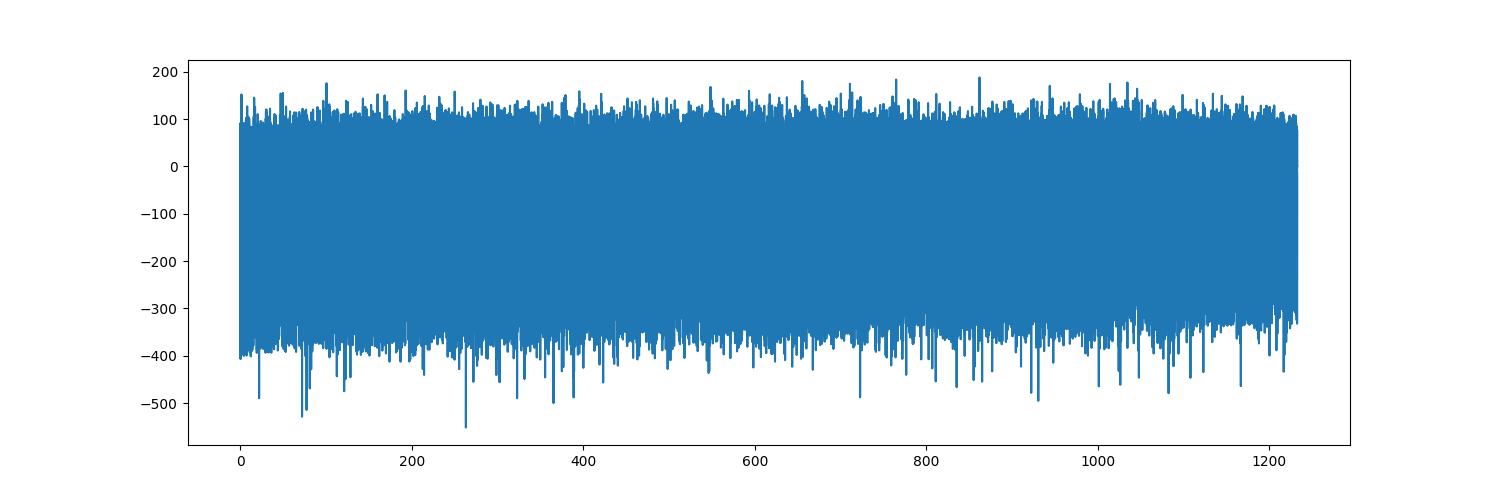

In [28]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,chan_data.shape[-1]/Fs,10/Fs),chan_data[::10])
# plt.plot(chan_data[1000000:1100000])

<IPython.core.display.Javascript object>


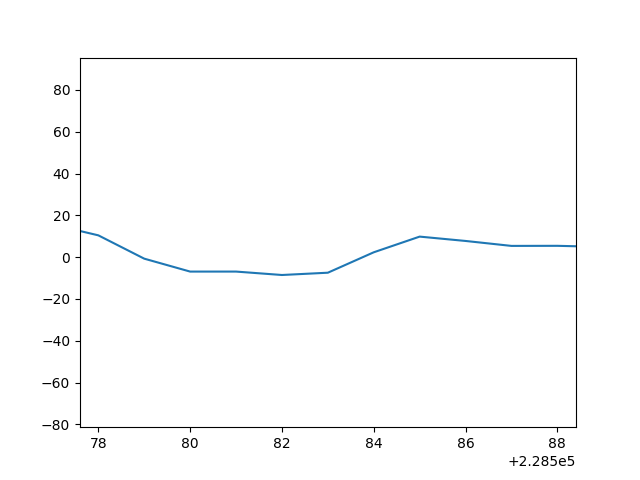

In [29]:
plt.figure()
plt.plot(chan_data[700*30000:710*30000])

In [65]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data, dt)
css.num_gmm_components = 7
css.cs_num_gmm_components = 5
css.cs_detection_batch_size = 100
css.pre_window = 0.0002
css.post_window = 0.0030
css.run(use_filtered=False, remove_overlap=False, spike_detection_dir = 'min', align_spikes_to='min')
print('Signal length = {}'.format(css.voltage.size*css.dt))
print('number of detected CS = {}'.format(css.cs_indices.size))

Pre-process...
Using minibatch spike detection, batch size = 50s, using filter (derivative) is False
Using spikes min for detection. Aligning them to their min. 
Spike detection time = 61.66200375556946
Using all spikes for alignment (no overlap removal)
Align spikes time = 0.03834056854248047
Clustering complex spikes...
Splitting detected spikes for CS clustering ...
CS spike detection time = 2.165109634399414
Merging overlapping CS waveforms
CS post process time = 0.0018563270568847656
Signal length = 1232.4864
number of detected CS = 1725


In [67]:
for mti in css.spike_indices:
    chan_data[mti - int(0.001*Fs):mti + int(0.001*Fs)] = np.random.normal(0,5,int(0.002*Fs))

In [68]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data, dt)
css.num_gmm_components = 3
css.cs_num_gmm_components = 5
css.cs_detection_batch_size = 100
css.pre_window = 0.0002
css.post_window = 0.0030
css.run(use_filtered=False, remove_overlap=False, spike_detection_dir = 'min', align_spikes_to='min')
print('Signal length = {}'.format(css.voltage.size*css.dt))
print('number of detected CS = {}'.format(css.cs_indices.size))

Pre-process...
Using minibatch spike detection, batch size = 50s, using filter (derivative) is False
Using spikes min for detection. Aligning them to their min. 
Spike detection time = 30.330968856811523
Using all spikes for alignment (no overlap removal)
Align spikes time = 0.4702341556549072
Clustering complex spikes...
Splitting detected spikes for CS clustering ...
CS spike detection time = 58.68369126319885
Merging overlapping CS waveforms
CS post process time = 0.02777242660522461
Signal length = 1232.4864
number of detected CS = 9763


In [ ]:
# css.cs_indices = np.delete(css.cs_indices, 0)

In [70]:
from sklearn.mixture import GaussianMixture
num_clusters = 6
pre_time = 0.0005
post_time = 0.0025
align_to='min'
slice_length = 100
delta = int(slice_length/css.dt)
if css.signal_size > (slice_length + slice_length/2.0)/css.dt:
    print('Splitting detected spikes for CS clustering ...')
    cs_slice_indices = []
    countall = 0
    for i in np.arange(0, css.signal_size, delta):
        cs_slice_indices.append(np.where(np.logical_and(css.cs_indices >= i ,  css.cs_indices < i + delta))[0])
    # If the last chunk is less than 2 minutes, merge it with the penultimate chunk:
    if cs_slice_indices[-1].size <= (slice_length/2.0)/css.dt:
        cs_slice_indices[-2] = np.concatenate((cs_slice_indices[-2], cs_slice_indices[-1]))
        del cs_slice_indices[-1]
else:
    cs_slice_indices = [np.arange(0, css.cs_indices.size)]



pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
clusters_for_slice = []
cluster_labels_for_slice = []
gmm = GaussianMixture(num_clusters, covariance_type = 'full', warm_start=False)
for ccslice in cs_slice_indices:
    if align_to is 'min':
        aligned_cs = np.array([css.voltage[i - pre_index : i + post_index] for i in css.cs_indices[ccslice]])
    elif align_to is 'max':
        aligned_cs = []
        for csi in css.cs_indices[ccslice]:
            align_point = np.argmax(css.voltage[csi - pre_index : csi + post_index]) + csi-pre_index
            aligned_cs.append(css.voltage[align_point - pre_index : align_point + post_index])
        aligned_cs = np.array(aligned_cs)
    else:
        raise ValueError("align_to should be min or max")
    gmm.fit(aligned_cs)
    cluster_labels = gmm.predict(aligned_cs)
    clusters = []
    for cn in np.arange(num_clusters):
        clusters.append(aligned_cs[np.where(cluster_labels == cn)])
    clusters_for_slice = clusters_for_slice + [clusters]
    cluster_labels_for_slice = cluster_labels_for_slice + [cluster_labels]



Splitting detected spikes for CS clustering ...


In [71]:
def plot_clusters(ax, i):
    clusters = clusters_for_slice[i]
    colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
    legend_labels = []
    for cn in np.arange(num_clusters):
        legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

    import gc
    gc.collect()
    
#     fig.figsize = (18,5)
    clust_means = []
    paxes = []
    for cn in np.arange(num_clusters):
        clust_means.append(np.mean(clusters[cn], axis=0))
        ax.plot(clust_means[-1], color = colors[cn], label = legend_labels[cn])
        paxes.append(ax)
    ax.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
    ax.legend() 
    ax.set_title('Batch #{}'.format(i))
    fig.canvas.draw()
    
    

In [72]:
import random
ss_indices = css.get_ss_indices()
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_ss = np.array([css.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])
mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), css.cs_indices.size), ], axis=0)

<IPython.core.display.Javascript object>


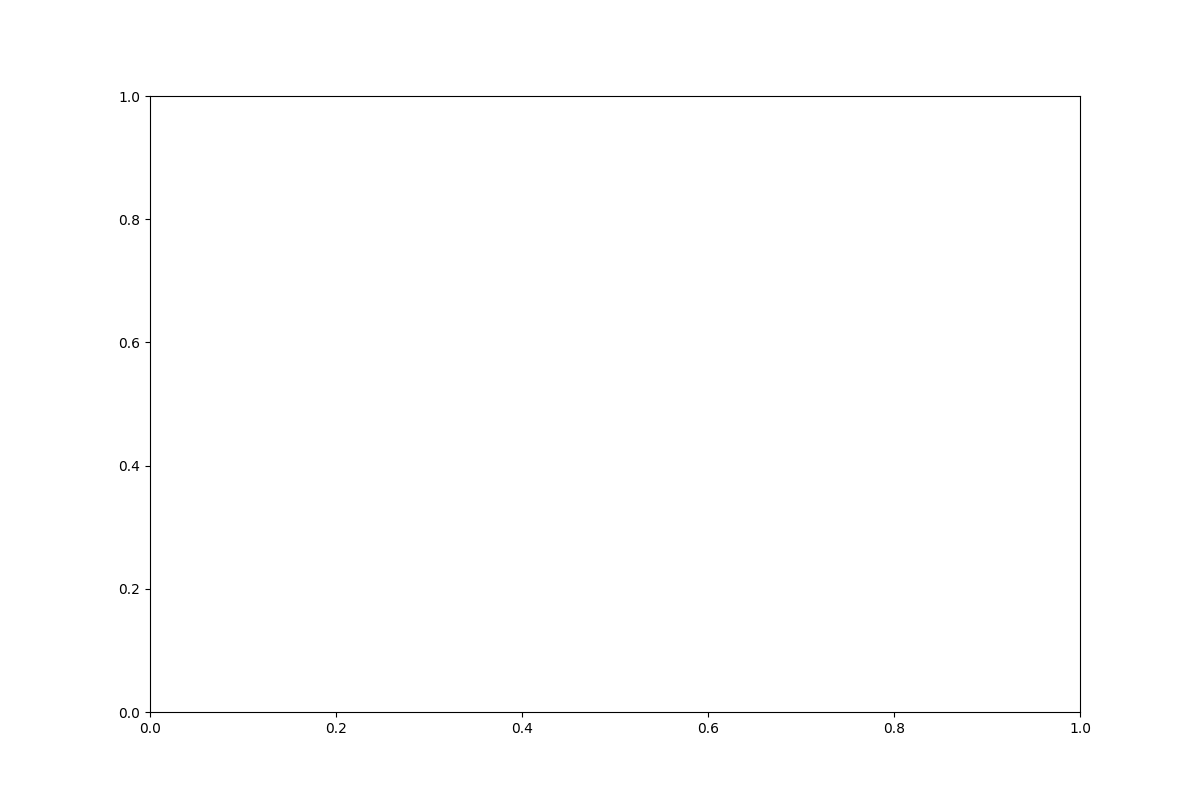

Text(value='')

In [73]:
import ipywidgets as widgets
fig,ax = plt.subplots(1,1,figsize=(12,8))
answers = []
plot_counter = [1]
plot_clusters(ax,0)
text = widgets.Text()
def handle_submit(sender):
    update_plot(answers)
    
def update_plot(answers):
    if plot_counter[0] < len(clusters_for_slice):
        ans_regex = re.compile(r'\d+(?:,\d+)?')
        if ans_regex.match(text.value):
            answers.append(text.value)
            ax.cla()
            plot_clusters(ax,plot_counter[0])
            plot_counter[0] = plot_counter[0] + 1
            text.value = ''

    else:
        answers.append(text.value)
        ax.cla()
        text.value = 'THAT\'S ALL'
#     return answers
text.on_submit(handle_submit)
display(text)



In [74]:
picked_clusters = [[int(c) for c in ans.split(',')] for ans in answers]
cs_indices_to_pick = []
for i, clusters_to_pick in enumerate(picked_clusters):
    for cti in clusters_to_pick:
        cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[cs_slice_indices[i]][np.where(cluster_labels_for_slice[i] == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices.shape))    
    

Number of detected CS: (1957,)


<IPython.core.display.Javascript object>


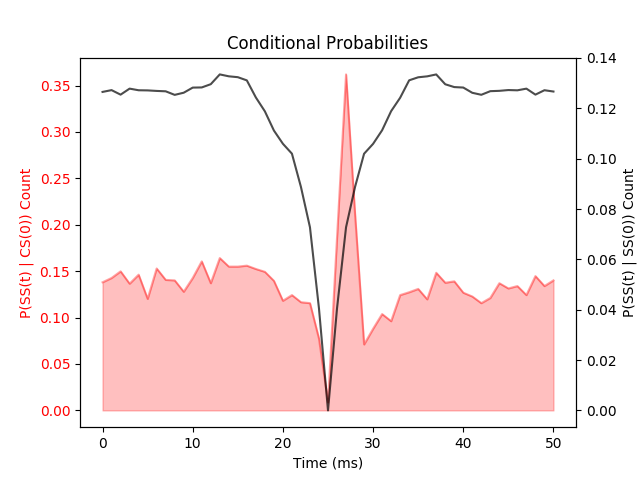

Text(0.5, 1.0, 'Conditional Probabilities')

In [75]:
window = 25

SS = np.zeros(np.int64(css.signal_size/(Fs/1000.0)))
SS[np.int64(ss_indices/(Fs/1000.0))] = 1
CS = np.zeros(np.int64(css.signal_size/(Fs/1000.0)))
CS[np.int64(cs_indices/(Fs/1000.0))] = 1



xcor_vect = np.zeros((2*window + 1))
first_cs_acor = np.argmax(cs_indices > window*(Fs/1000.0))
last_cs_acor = np.argmax(cs_indices[::-1] < ss_indices[-1] - window*30) + 1
for cti in np.int64(cs_indices[first_cs_acor:-1]/(Fs/1000.0)):
    xcor_vect = xcor_vect + SS[cti-window : cti + window + 1]

xcor_vect = xcor_vect / (cs_indices.size - (first_cs_acor + last_cs_acor))
    
acor_vect = np.zeros((2*window + 1))
first_ss_acor = np.argmax(ss_indices > window*(Fs/1000.0))
last_ss_acor = np.argmax(ss_indices[::-1] < ss_indices[-1] - window*(Fs/1000.0)) + 1
for sti in np.int64(ss_indices[first_ss_acor:-last_ss_acor]/(Fs/1000.0)):
    acor_vect = acor_vect + SS[sti-window : sti + window + 1]

acor_vect[window] = 0

acor_vect = acor_vect / (ss_indices.size - (first_ss_acor + last_ss_acor))

plt.figure()
plt.plot(xcor_vect, 'r', alpha=0.35)
plt.yticks(color='r')
plt.fill_between(np.arange(0,2*window + 1), xcor_vect, color='r', alpha=0.25)
plt.ylabel('P(SS(t) | CS(0)) Count', color = 'r')
plt.xlabel('Time (ms)')

plt.twinx()
plt.plot(acor_vect, 'k', alpha=0.70)
plt.yticks(color='k')
plt.ylabel('P(SS(t) | SS(0)) Count', color = 'k')
# plt.fill_between(acor_ret[0], 0, acor_ret[1] , color='g', alpha=0.25)
plt.title('Conditional Probabilities')

In [20]:
plt.savefig(os.path.join(source_path, 'CH_{}.png'.format(chan_index)))
plt.savefig(os.path.join(source_path, 'CH_{}.svg'.format(chan_index)))
         

<IPython.core.display.Javascript object>


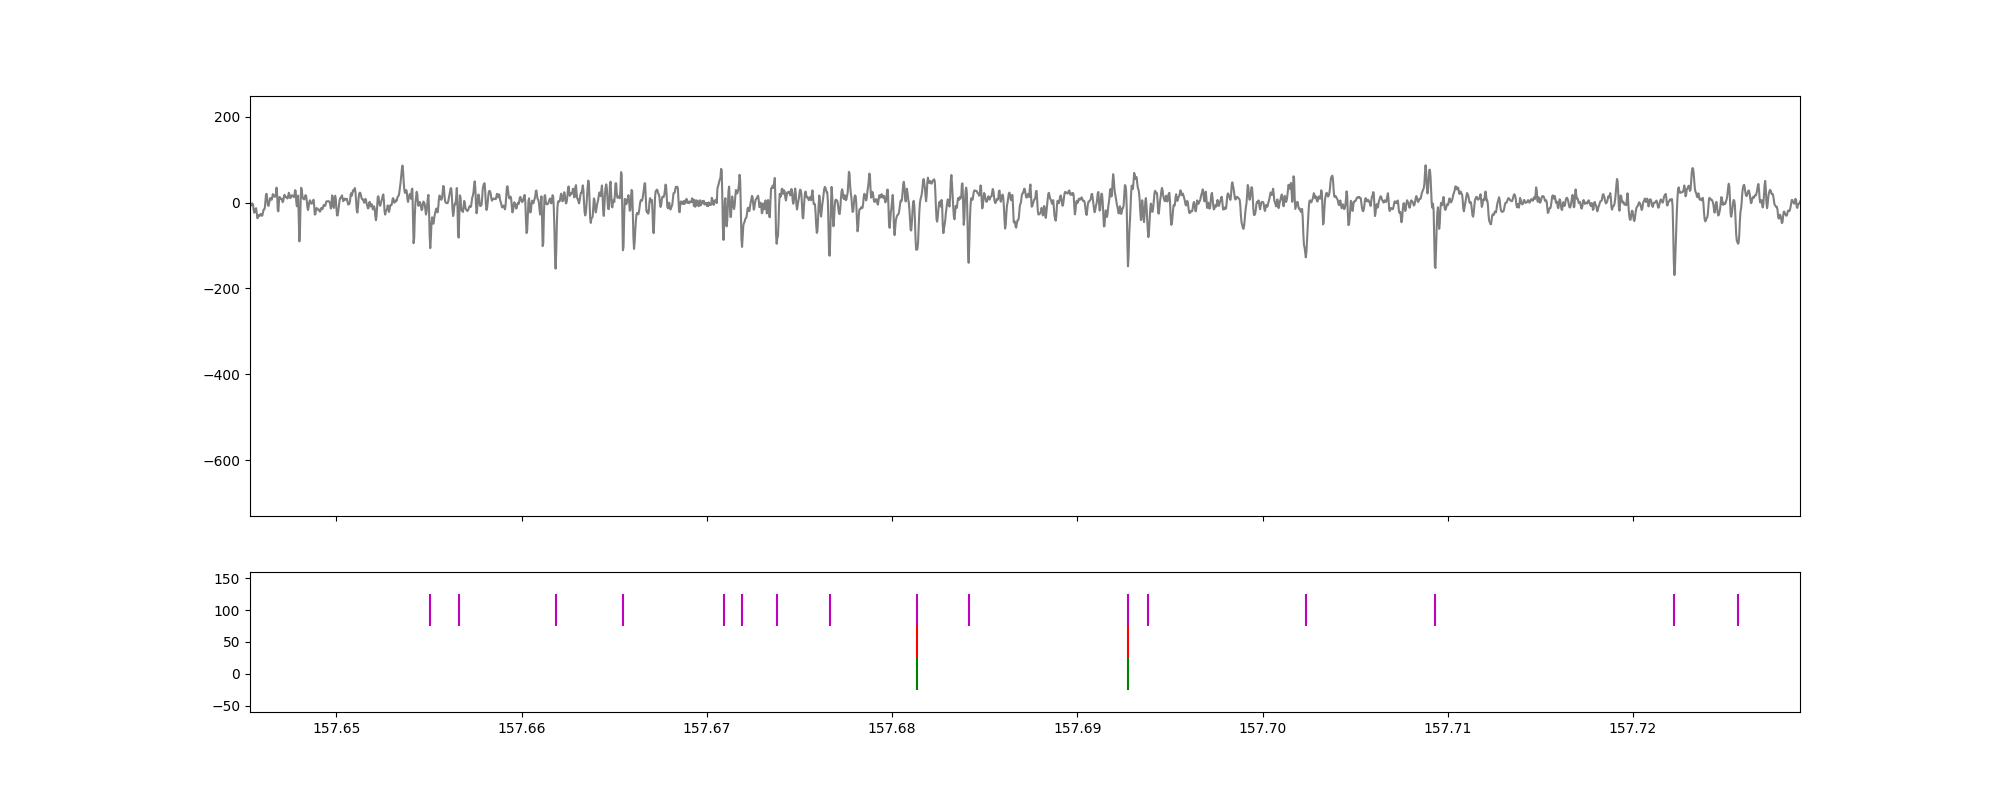

In [76]:
# plot channel
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,8), sharex=True)

# prange = [0,css.signal_size*css.dt]
# prange = [css.signal_size*css.dt - 100, css.signal_size*css.dt] #s
prange = [150,200] #s
idx_voltage = [int(pr*Fs) for pr in prange]
ax0.plot(np.arange(prange[0],prange[1],1/Fs), css.voltage[idx_voltage[0]: idx_voltage[1]], alpha=0.5, color='k')
ax1.eventplot(css.cs_indices[np.where(np.logical_and(css.cs_indices < idx_voltage[1] , css.cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=0, color='g')
ax1.eventplot(cs_indices[np.where(np.logical_and(cs_indices < idx_voltage[1] , cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=50, color='r')
ax1.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices < idx_voltage[1] , css.spike_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=100, color='m')
# plt.plot(chan_data[chan_index,::10])
# plt.title('Channel {}. Signal length = {}s'.format(chan_index, chan_data.shape[1]/Fs))

In [19]:
CS_csv_filename = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
SS_csv_filename = os.path.join(source_path, 'channel_{}.SS.csv'.format(chan_index))

import csv
with open(CS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(CS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(cs_indices.reshape(-1,1))
    
with open(SS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(SS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(ss_indices.reshape(-1,1))

writing ../data/OpenEphys_data/2019-03-27/2019-03-27_13-58-03/channel_4.CS.csv ... 
writing ../data/OpenEphys_data/2019-03-27/2019-03-27_13-58-03/channel_4.SS.csv ... 


# 2. Loading behavioral data and detect saccades/target jumps

In [ ]:
source_path

In [ ]:
# fname_OE_x = os.path.join(source_path,'100_ADC2.continuous')
# fname_OE_y = os.path.join(source_path,'100_ADC1.continuous')

fname_OE_x = f_names[-1]
fname_OE_y = f_names[-1]

messages_fname = os.path.join(source_path, 'messages.events')
events_file = os.path.join(source_path, 'all_channels.events')

In [ ]:
behavioral_fname

In [ ]:
fhd_content = load(behavioral_fname)

HT = np.squeeze(fhd_content['target_x'])
VT = np.squeeze(fhd_content['target_y'])
HE = np.squeeze(fhd_content['right_horizontal_eye'])
VE = np.squeeze(fhd_content['right_vertical_eye'])
eye = np.linalg.norm(np.vstack((HE, VE)), axis = 0)
# target = np.linalg.norm(np.vstack((target_x, target_y)), axis = 0)
el_t = np.squeeze(fhd_content['t'])
eye_t = np.squeeze(fhd_content['eyelink_time'])

trials = fhd_content['trials']

In [ ]:
bias_eyelink_time = eye_t[0] - el_t[0]

In [ ]:
for k,v in zip(trials[4].keys(), trials[4].values()):
    print('{} : {}'.format(k,v))

# Loading state times from behavioral data
class trial_events:
    pass

trialevents = []
for trial in trials:
    trial_event = trial_events()
#     if not np.array_equal(trial['state_start_time_cue_target_present'], trial['state_start_time_detect_sac_start']):
#         print(trial['state_start_time_cue_target_present'], trial['state_start_time_detect_sac_start'])
    
    for k,v in zip(trial.keys(), trial.values()):
        exec('trial_event.' + k + '=v')
    trialevents.append(trial_event)

In [ ]:
str_target_fixation_times = [te.state_start_time_str_target_fixation for te in trialevents if hasattr(te, 'state_start_time_str_target_fixation')]
str_target_fixation_times = np.squeeze(np.hstack(str_target_fixation_times))

target_presentation_time = [te.state_start_time_cue_target_present for te in trialevents if hasattr(te, 'state_start_time_cue_target_present')]
target_presentation_time = np.squeeze(np.hstack(target_presentation_time))

iti_times = [te.state_start_time_iti for te in trialevents if hasattr(te, 'state_start_time_iti')]
iti_times = np.squeeze(np.hstack(iti_times))

target_pursuit_start_times =  [te.state_start_time_str_target_pursuit for te in trialevents if hasattr(te, 'state_start_time_str_target_pursuit')]
target_pursuit_start_times = np.squeeze(np.hstack(target_pursuit_start_times))

detect_sac_end_times =  [te.state_start_time_detect_sac_end for te in trialevents if hasattr(te, 'state_start_time_detect_sac_end')]
detect_sac_end_times = np.squeeze(np.hstack(detect_sac_end_times))

deliver_reward_times =  [te.state_start_time_deliver_reward for te in trialevents if hasattr(te, 'state_start_time_deliver_reward')]
deliver_reward_times = np.squeeze(np.hstack(deliver_reward_times))

In [ ]:
# Zeroing the time on behavioral data and event times
detect_sac_end_times = detect_sac_end_times - el_t[0]
str_target_fixation_times = str_target_fixation_times - el_t[0]
target_presentation_time = target_presentation_time - el_t[0]
iti_times = iti_times - el_t[0]
target_pursuit_start_times = target_pursuit_start_times - el_t[0]
deliver_reward_times = deliver_reward_times - el_t[0]
eye_t = eye_t - el_t[0]
el_t = el_t - el_t[0]


In [ ]:
# # Loading network event data from Open Ephys data
# with open(messages_fname, 'r') as f:
#     file_content = f.readlines()
# Fs = float(file_content[1].split('@')[-1][0:-3])
# time0 = int(file_content[1].split(' ')[0])
# net_events_prim = np.array([[l.split(' ')[0], l.split(' ')[1][1:]] for l in file_content if len(l.split(' ')) == 2 and 'P' in l.split(' ')[-1]]).astype(np.int)
# net_events_corr = np.array([[l.split(' ')[0], l.split(' ')[1][1:]] for l in file_content if len(l.split(' ')) == 2 and 'C' in l.split(' ')[-1]]).astype(np.int)
# net_events_prim[:,0] = net_events_prim[:,0] - time0
# net_events_corr[:,0] = net_events_corr[:,0] - time0
# directions_prim, counts_prim = np.unique(net_events_prim[:,1], return_counts=True)
# directions_corr, counts_corr = np.unique(net_events_corr[:,1], return_counts=True)

In [ ]:
# Loading eye position from Open Ephys data
file_content = OpenEphys.load(fname_OE_x)
Fs = float(file_content['header']['sampleRate'])
eye_OE_x = file_content['data']
file_content = OpenEphys.load(fname_OE_y)
eye_OE_y = file_content['data']
time_stamps = file_content['timestamps']
voltage_t = np.interp(np.arange(eye_OE_x.size), np.arange(0, eye_OE_x.size, eye_OE_x.size/time_stamps.size), time_stamps)

In [ ]:
# Load DIO events from Open Ephys data
event_number = 1 # which DIO event to sync to
events_content = OpenEphys.load(events_file)
event_t = events_content['timestamps']
eventId = events_content['eventId']
channelId = events_content['channel']

sync_events = event_t[np.where(np.logical_and(channelId == event_number,eventId == 1))] # eventId = 1: rising edge, eventId = 0: falling edge
sync_events = sync_events - voltage_t[0]
voltage_t = voltage_t - voltage_t[0]
voltage_t = voltage_t/Fs
sync_events = sync_events/Fs

In [ ]:
# Syncing behavioral time to open ephys time with DIO events
time_diff = sync_events[0] - str_target_fixation_times[0] # start fixation state corresponds to event_number = 3
print('DIO event time differeence = {}'.format(time_diff))
el_t_syncd_with_dio_event = el_t + time_diff
eye_t_syncd_with_dio_event = eye_t + time_diff

In [ ]:
# # Syncing to Network events
# time_diff = net_events_corr[0,0]/Fs - detect_sac_end_times[0] # detect_sac_end state corresponds to the network event for corrective saccade
# print('Network event time differeence = {}'.format(time_diff))
# el_t_syncd_with_network_event = el_t + time_diff
# eye_t_syncd_with_network_event = eye_t + time_diff

In [ ]:
detect_sac_end_times = detect_sac_end_times + time_diff
str_target_fixation_times = str_target_fixation_times + time_diff
target_presentation_time = target_presentation_time + time_diff
iti_times = iti_times + time_diff
target_pursuit_start_times = target_pursuit_start_times + time_diff
deliver_reward_times = deliver_reward_times + time_diff

In [ ]:
# Assign the synchronized time stamps to the Eye and Target data
# t_HT = el_t_syncd_with_network_event
# t_HE = el_t_syncd_with_network_event
# t_VT = el_t_syncd_with_network_event
# t_VE = el_t_syncd_with_network_event


t_HT = el_t_syncd_with_dio_event
t_HE = el_t_syncd_with_dio_event
t_VT = el_t_syncd_with_dio_event
t_VE = el_t_syncd_with_dio_event



In [ ]:
# Calculate target and eye velocity
from scipy.signal import savgol_filter 
VT_v_filtered = savgol_filter(np.squeeze(VT), window_length=15, polyorder=2, deriv=1, delta = 0.001)
HT_v_filtered = savgol_filter(np.squeeze(HT), window_length=15, polyorder=2, deriv=1, delta = 0.001)
T_v_filtered = np.linalg.norm(np.vstack((VT_v_filtered, HT_v_filtered)), axis = 0)

VE_v_filtered = savgol_filter(np.squeeze(VE), window_length=15, polyorder=2, deriv=1, delta = 0.001)
HE_v_filtered = savgol_filter(np.squeeze(HE), window_length=15, polyorder=2, deriv=1, delta = 0.001)
E_v_filtered = np.linalg.norm(np.vstack((VE_v_filtered, HE_v_filtered)), axis = 0)


In [ ]:
# Saccade and target-jump detection
from kaveh.behavioral.oculomotor.session import session
mysess = session(HT, t_HT, VT, t_VT, HE, t_HE, VE, t_VE, 1000.0, 0.001)
mysess._cut_to_min_size()
mysess._calc_target_velocity()
mysess._calc_saccade_velocity()

mysess._detect_target_jumps(v_thresh = 70, onoff_thresh = 30)
mysess._detect_saccades(v_thresh = 120, onoff_thresh = 30)

In [ ]:
# Finding inter-saccadinc target jumps
import quantities as pq

# iss_range = pq.quantity.Quantity(0.025, 's')
iss_range = 0.025
iss_targets = []
iss_saccades = []
saccades_with_no_iss_target = []

for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
#     iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
#                                                              mysess.target_onset_times > son - iss_range), 
#                                               np.logical_and(mysess.target_offset_times < soff + iss_range, 
#                                                              mysess.target_offset_times > soff - iss_range)))[0])
    iss_targets.append(np.where(np.logical_and(mysess.target_onset_times > son - iss_range , mysess.target_offset_times < soff + iss_range))[0])
    if iss_targets[-1].size != 0:
        iss_saccades.append(i)
    if iss_targets[-1].size == 0:
        saccades_with_no_iss_target.append(i)

iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)

# Only iss target jumps that are considered succressful trial (if reward delivered less than 400 ms after the onset)
iss_targets_successful_trials = np.array([ist for ist in iss_targets if np.where(np.logical_and(deliver_reward_times > t_VT[mysess.target_offsets[ist]] ,
                                                                                                deliver_reward_times < t_VT[mysess.target_offsets[ist]] + 0.600) )[0].size !=0])
# iss_targets_successful_trials = iss_targets
# Only primary target jumps with successful following primary saccade leading to successful trial
non_iss_target_jumps_with_successfull_following_iss_tj = np.array([nist for nist in non_iss_target_jumps if np.where(np.logical_and(
    np.logical_and(mysess.target_onset_times[iss_targets_successful_trials] > mysess.target_offset_times[nist], 
                   mysess.target_onset_times[iss_targets_successful_trials] < mysess.target_offset_times[nist] + 0.600), 
    np.where(np.logical_and(mysess.target_onset_times[non_iss_target_jumps] > mysess.target_offset_times[nist], 
                       mysess.target_onset_times[non_iss_target_jumps] < mysess.target_offset_times[nist] + 0.600))[0].size == 0 ))[0].size !=0])
# Only primary target jumps with a following saccade (doesn't have to be a successful saccade/trial)
non_iss_target_jumps_with_following_iss_tj = np.array([nist for nist in non_iss_target_jumps if np.where(np.logical_and(mysess.target_onset_times[iss_targets] > mysess.target_offset_times[nist] ,
                                                                                                mysess.target_onset_times[iss_targets] < mysess.target_offset_times[nist] + 0.600) )[0].size !=0])

# # Finding reaction times
# saccade_rt = []
# saccade_rt_target_offset_times = []
# saccade_rt_target_offset_indices = []
# for i, toff in enumerate(mysess.target_offset_times[non_iss_target_jumps]):

#     delay_to_next_saccade = mysess.saccade_onset_times[np.argmax(mysess.saccade_onset_times > toff)] - toff
#     delay_to_next_target_jump = mysess.target_onset_times[non_iss_target_jumps][np.argmax(mysess.target_onset_times[non_iss_target_jumps] > toff)] - toff
#     # Only consider reaction times that are less than 600ms and are occurring before the next target jump
#     if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
#         saccade_rt.append(delay_to_next_saccade)
#         saccade_rt_target_offset_times.append(toff)
#         saccade_rt_target_offset_indices.append(i)

# saccade_rt = np.squeeze(np.array(saccade_rt))
# saccade_rt_target_offset_times = np.squeeze(np.array(saccade_rt_target_offset_times))
# saccade_rt_target_offset_indices = np.squeeze(np.array(saccade_rt_target_offset_indices))




#################################################33
def calc_saccade_reaction_time_to_target_offset(session, target_offset_indices_to_include):
    """
    Function for finding reaction times to targets
    """
    saccade_rt = []
    saccade_rt_target_offset_times = []
    saccade_rt_target_offset_indices = []
    
    for toff, i in zip(session.target_offset_times[target_offset_indices_to_include], target_offset_indices_to_include):
    
        delay_to_next_saccade = session.saccade_onset_times[np.argmax(session.saccade_onset_times > toff)] - toff
        delay_to_next_target_jump = session.target_onset_times[np.argmax(session.target_onset_times > toff)] - toff
        # Only consider reaction times that are less than 600ms and are occurring before the next target jump
        if delay_to_next_saccade <= delay_to_next_target_jump + 0.025 and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
            saccade_rt.append(delay_to_next_saccade)
            saccade_rt_target_offset_times.append(toff)
            saccade_rt_target_offset_indices.append(i)

    saccade_rt = np.squeeze(np.array(saccade_rt))  # reaction times
    saccade_rt_target_offset_times = np.squeeze(np.array(saccade_rt_target_offset_times)) # target offset times for which the reaction times were calculated
    saccade_rt_target_offset_indices = np.squeeze(np.array(saccade_rt_target_offset_indices)) # indices of target offset times for which the reaction times were calculated
    
    return (saccade_rt, saccade_rt_target_offset_times, saccade_rt_target_offset_indices)

(rt, rt_toffs, rt_toff_indices) = calc_saccade_reaction_time_to_target_offset(mysess, non_iss_target_jumps_with_following_iss_tj)
    


In [ ]:
non_iss_target_jumps_with_following_iss_tj.shape

In [ ]:
non_iss_target_jumps_with_successfull_following_iss_tj.shape

In [ ]:
plt.figure()
plt.hist(rt, bins=50)

In [ ]:
import gc
gc.collect()

plt.figure()
ax1 = plt.subplot(411)
plt.plot(t_HT, HT)
plt.plot(t_HE, HE, '--')
h = plt.ylabel('Hor Target/Eye (deg)')
# h.set_rotation(-45)
plt.subplot(412, sharex=ax1, sharey=ax1)
plt.plot(t_VT, VT)
plt.plot(t_VE, VE, '--')
plt.ylabel('Ver Target/Eye (deg)')
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(t_VT, T_v_filtered)
plt.ylabel('Target Velocity (deg/s)')
# plt.eventplot(t_VE[rising], linelengths=1000, colors='r', zorder=10, alpha = 0.4)
# plt.eventplot(t_VT[mysess.target_onsets],linelengths=1000, colors='g', zorder=10, alpha = 0.4)
# plt.eventplot(t_VT[mysess.target_onsets[iss_targets_successful_trials]],linelengths=1000, colors='r', zorder=10, alpha = 1)
# plt.eventplot(t_VT[mysess.target_offsets],linelengths=1000, colors='k', zorder=10, alpha = 0.4)
# plt.eventplot(mysess.target_offset_times[non_iss_target_jumps_with_successfull_following_iss_tj],linelengths=5000, colors='m', zorder=10, alpha = 0.9)
# plt.eventplot(deliver_reward_times,linelengths=1000, colors='b', zorder=10, alpha = 0.4)
plt.eventplot(rt_toffs,linelengths=1000, colors='k', zorder=10, alpha = 0.4)

ax4 = plt.subplot(414, sharex=ax1, sharey=ax3)
plt.plot(t_VE, E_v_filtered)
plt.ylabel('Eye Velocity (deg/s)')
plt.xlabel('Time (s)')
# plt.eventplot(t_VE[rising], linelengths=1000, colors='r', zorder=10, alpha = 0.4)
# plt.eventplot(t_VE[mysess.saccade_onsets],linelengths=1000, colors='g', zorder=10, alpha = 0.4)
# plt.eventplot(t_VE[mysess.saccade_offsets],linelengths=1000, colors='k', zorder=10, alpha = 0.4)
plt.eventplot(rt_toffs,linelengths=1000, colors='k', zorder=10, alpha = 0.4)
plt.show()


In [ ]:
# saving mysess
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

output_fn = behavioral_fname + '.session.pkl'
with open(output_fn, 'wb') as output:
    print('writing {} ...'.format(output_fn))
    pickle.dump(mysess, output, pickle.HIGHEST_PROTOCOL)

from scipy.io import savemat
output_fn = behavioral_fname + '.session.mat'
savemat(output_fn, {'iss_targets' : iss_targets,
'non_iss_target_jumps' : non_iss_target_jumps,
'iss_targets_successful_trials' : iss_targets_successful_trials,
'non_iss_target_jumps_with_successfull_following_iss_tj' : non_iss_target_jumps_with_successfull_following_iss_tj,
'non_iss_target_jumps_with_following_iss_tj' : non_iss_target_jumps_with_following_iss_tj})
print('writing {} ...'.format(output_fn))


# Calculate CS probability with respect to reaction time

In [ ]:
def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
#     cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)

In [ ]:
bin_edges = [np.percentile(rt,q) for q in [25, 50, 75]]
bin_ind_sac_delays = np.digitize(rt, bins = bin_edges)

In [ ]:
cs_times = voltage_t[cs_indices]

In [ ]:
(cs_counts_on, cs_probs_on, bin_sizes_on) = get_bin_cs_counts(0.200, rt_toffs, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_times)

In [ ]:
plt.figure()
plt.plot(cs_probs_on)